# Assignment #4

READ ALL INSTRUCTIONS CAREFULLY

This assignment is a puzzle. You have been given a data set with some semi-informative column headers but no additional information about it. Your goal is to investigate the data, understand as much about it as you can, and report back what you find.

You are free to use any and all of the techniques we have covered this semester: EDA, data wrangling, visualization (scatter plots, line plots, histograms, jointplots, etc.), descriptive statistics (mean, median, variance, covariance, etc.), regression / model fitting, loss functions (MSE, MAE), R^2, cross-validation, bootstrapping, gradient descent, etc... 

There are many different ways to approach this assignment and be successful. I recommend starting simple and getting slowly more sophisticated as needed.

## Collaborators

You must work in groups of 2-3. You cannot work on this assignment alone. Your partners cannot be anyone you have partnered with previously on an assignment and they cannot be in your group for the semester project.

**Names of all collaborators go here** (including yourself):

## Tools

You are not allowed to use LLMs (including the LLM results that pop up in Google search). You may use search online for ideas, use StackExchange, and I highly encourage using Python library documentation.

Hint: It may be useful to use the sklearn library for model fitting (and not to implement model fitting or optimization by hand).

## Submission Instructions

You must submit two files. One is your **Jupyter notebook** that you use to explore and analyze the data. The second file is a separate **PDF** reporting, presenting, and explaining your results with no code in it.

**Only one person** in your group should submit the assignment files on Canvas. Be sure everyone's names are listed under collaborators in both the notebook and the PDF so everyone gets credit!

## Potentially Helpful Documentation


https://scikit-learn.org/stable/api/sklearn.model_selection.html

https://scikit-learn.org/stable/modules/linear_model.html

https://scikit-learn.org/stable/api/sklearn.metrics.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

# Your Code Below

## Imports and CoW

In [39]:
# Add all of your import statements here. ONLY include the imports you actually use. There are useful tools in the scikit-learn library for regression and model fitting, but you are not required to use it. If you use it, you will need to install it into your virtual environment.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, cross_val_score
# from sklearn.<something> import <something>

In [40]:
# Enforce Copy-on-Write (CoW) semantics here


## Project Folder Organization and File Reading

You must read in the given data file using relative paths, as shown in previous assignments. Organize your work to be in a project folder, with src and data subfolders. Place your solution notebook in the src folder, and the given data file in the data folder.

In [41]:
# Read in the data file (using relative paths for reproducibility). It should be able to download your notebook, put it in the src folder of my project folder, and run it without changing anything.
df = pd.read_csv("../data/mystery-1.csv", delimiter='|')

print(df.describe(include='all'))

                 x            y            z           d1           d2  \
count  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000   
mean     44.702607    53.394344    35.514137   138.298107     3.278987   
std      70.720754    74.296663    68.185888   159.671681    79.173899   
min    -999.000000  -999.000000  -999.000000  -999.000000  -999.000000   
25%      35.862902    32.303485    37.941742    24.969669   -28.312801   
50%      47.474927    57.428922    39.920321   142.894013   -10.266625   
75%      62.189990    81.894692    42.012014   252.666808    32.307670   
max      93.248123   109.814680    48.870364   474.250238   193.247985   

                d3            d4            c  
count  1854.000000   1854.000000  1854.000000  
mean     33.312987  28604.297833     6.002157  
std      67.983135  26765.170592     3.737760  
min    -999.000000  -6575.228052     0.000000  
25%      36.854105   4106.422132     3.000000  
50%      37.698475  21852.839683     6.000000

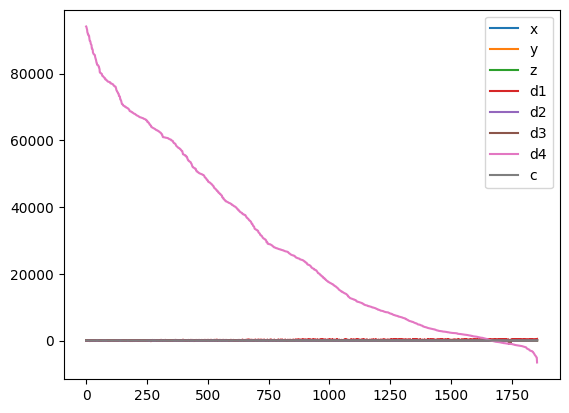

In [42]:
#Graph the information
plt.plot(df)

plt.legend(df.columns)

c:\Users\mbuck\OneDrive\Documents\CS577\Assignment4\Assignment4\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Text(0.5, 1.0, 'Graph of log(data)')

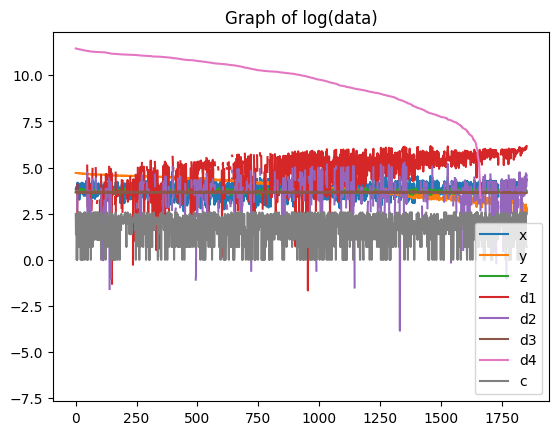

In [43]:
#Graph does not have any specific/useful infromation at a glance, other than that d4 follows a compltely different trend than the rest of the data

#Lets look at the log of the graph
log_df = np.log(df+1) #Adding 1 to avoid log(0)
plt.figure()
plt.plot(log_df)
plt.legend(log_df.columns)
plt.title("Graph of log(data)")

In [44]:
#Our log graph doesn't really show us anything fruitful, other than that x,y,z,d1,d2,d3 al track together and have high correlation withone another. So maybe we should move on

#Let's remove the values at -999, this may help normalize our data
df = df[df['x'] != -999]

df.describe(include = 'all')

,x,y,z,d1,d2,d3,d4,c
count,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000
mean,49.225695,57.955099,39.997406,143.226810,7.622558,37.786716,28732.589481,6.000000
std,16.713001,26.847766,2.974248,141.325319,43.828991,0.964186,26751.900963,3.742671
min,10.520750,10.135119,30.190542,-203.894934,-33.540389,36.589368,-6575.228052,0.000000
25%,36.033403,32.681073,37.977585,27.098028,-28.148776,36.857343,4289.079588,3.000000
50%,47.551269,57.714450,39.945382,143.530673,-10.101627,37.703620,22295.512173,6.000000
75%,62.237845,81.930778,42.018724,253.332106,32.481449,38.596542,50345.835908,9.000000
max,93.248123,109.814680,48.870364,474.250238,193.247985,39.963298,94095.637152,12.000000


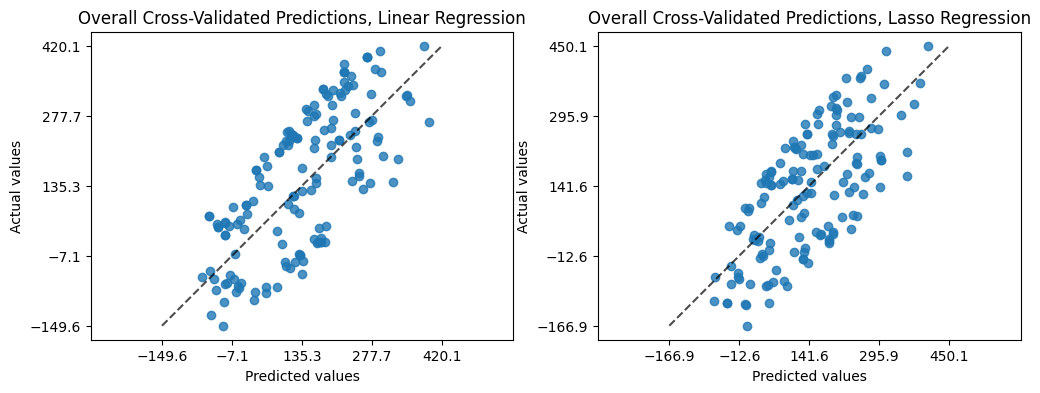

In [45]:
#trying k fold cross validation
kf = KFold(n_splits=10, shuffle=False, random_state=None)

#Linear Regression Line for our Model (Maybe dont use it here lol, different regression line than linear maybe?)
model = linear_model.LinearRegression()
#I also saw the lasso being used in the documentation, upon further digging, Lasso Regression is a regression analysis used for variable selection and regularization,
# seems Lasso is commonly used to avoid overfitting
lasso = linear_model.Lasso(alpha=0.1)

#Test with x and d1
x = df['x']
d1 = df['d1']

x = x.values.reshape(-1,1)
d1 = d1.values.reshape(-1,1)


# Perform cross-validation prediction on the x vs d1 data, to see if there's any relation
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, x, d1, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, x, d1, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

#Display our predictions
PredictionErrorDisplay.from_predictions(d1, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(d1, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

#Lasso Regression seems to work well. Both of the regression models seem to atleat show a correlation between our actual and predicted values,
#with our normal Linear Regression model seems to have more of the predictions closer to the line.

In [46]:
#This looks promising! Normalize our arrays from df now
y = df['y']
z = df['z']
d2 = df['d2']
d3 = df['d3']
d4 = df['d4']
c = df['c']

#Reshape so they can be used
y = y.values.reshape(-1,1)
z = z.values.reshape(-1,1)
d2 = d2.values.reshape(-1,1)
d3 = d3.values.reshape(-1,1)
d4 = d4.values.reshape(-1,1)
c = c.values.reshape(-1,1)

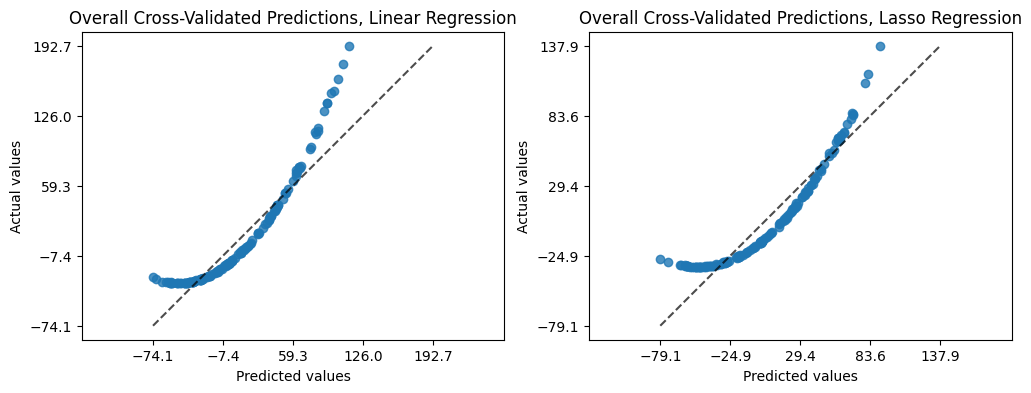

In [47]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, x, d2, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, x, d2, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(d2, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(d2, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

#W

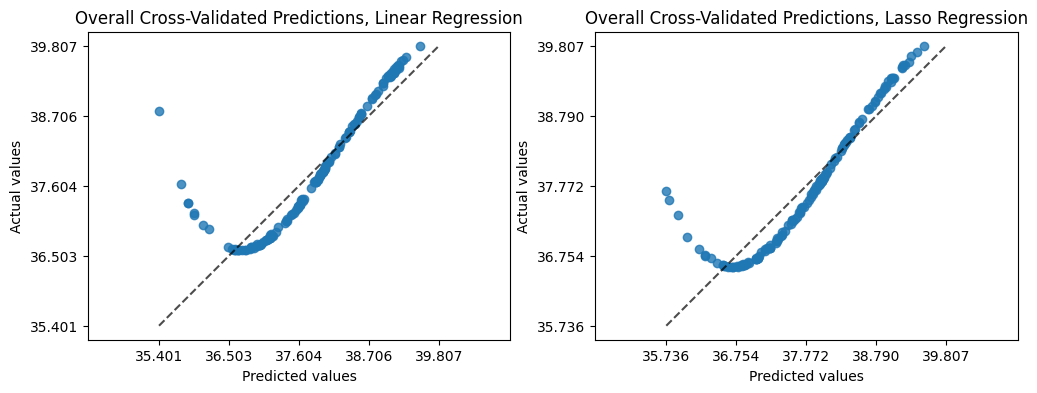

In [48]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, x, d3, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, x, d3, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(d3, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(d3, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

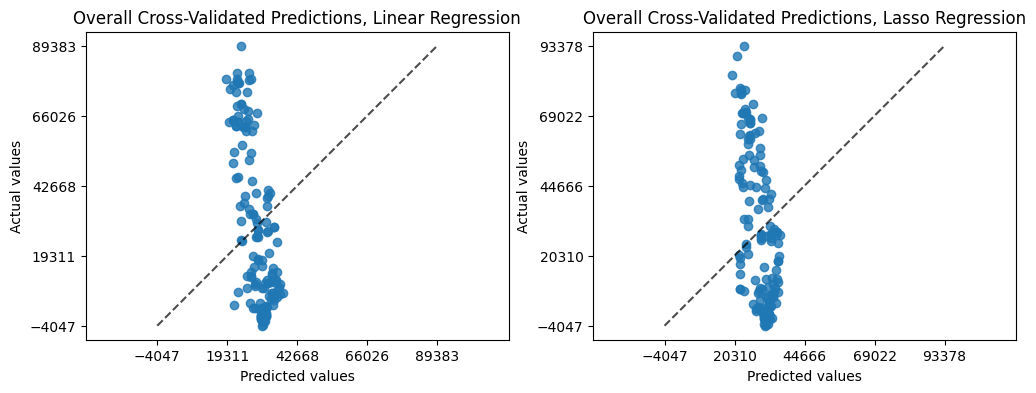

In [49]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, x, d4, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, x, d4, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(d4, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(d4, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

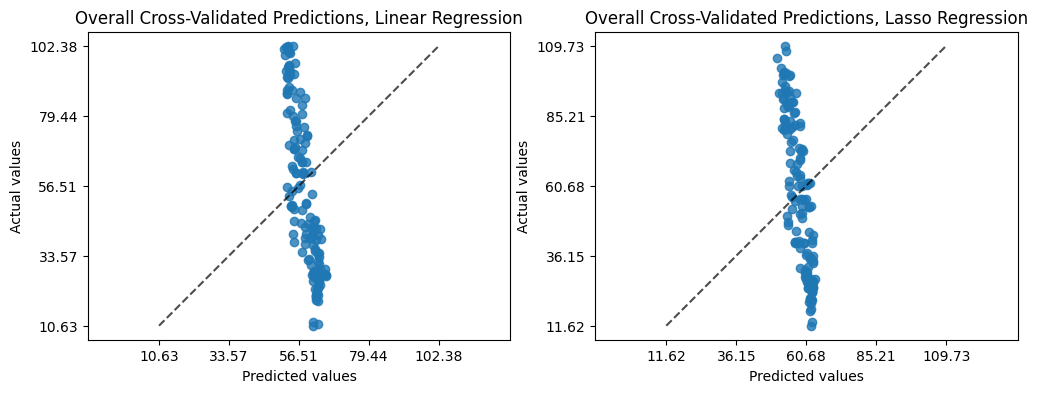

In [50]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, x, y, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, x, y, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(y, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(y, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

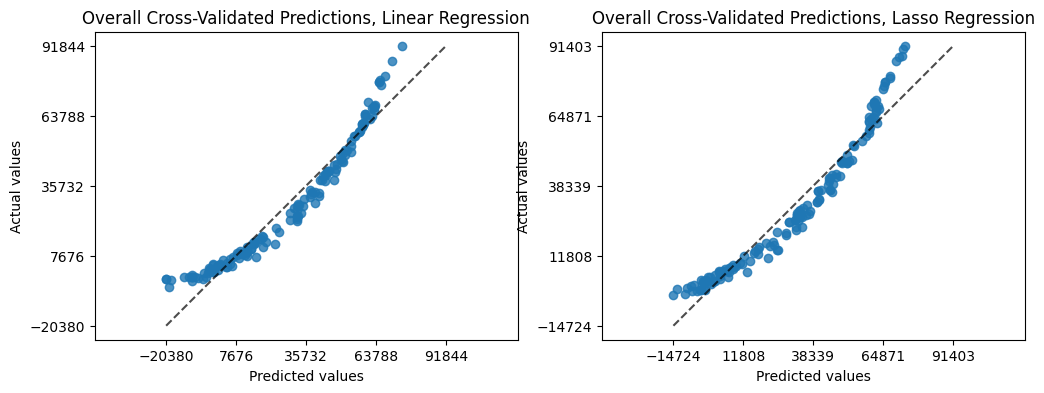

In [51]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, y, d4, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, y, d4, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(d4, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(d4, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

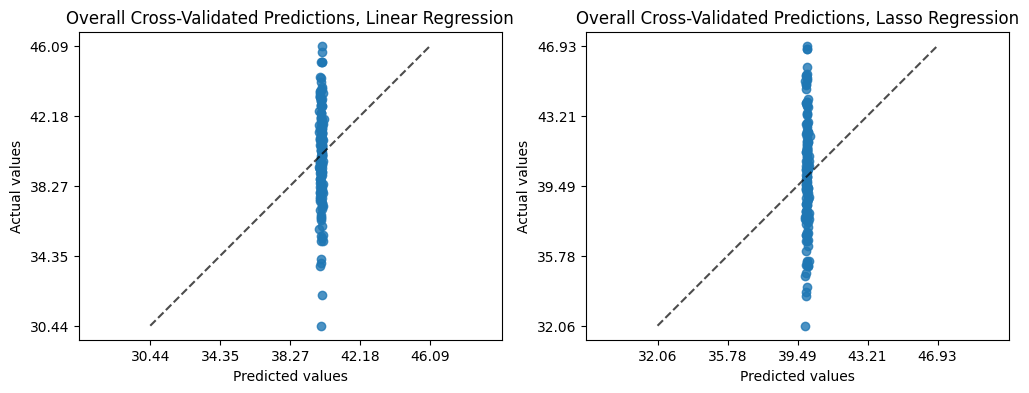

In [52]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, x, z, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, x, z, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(z, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(z, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

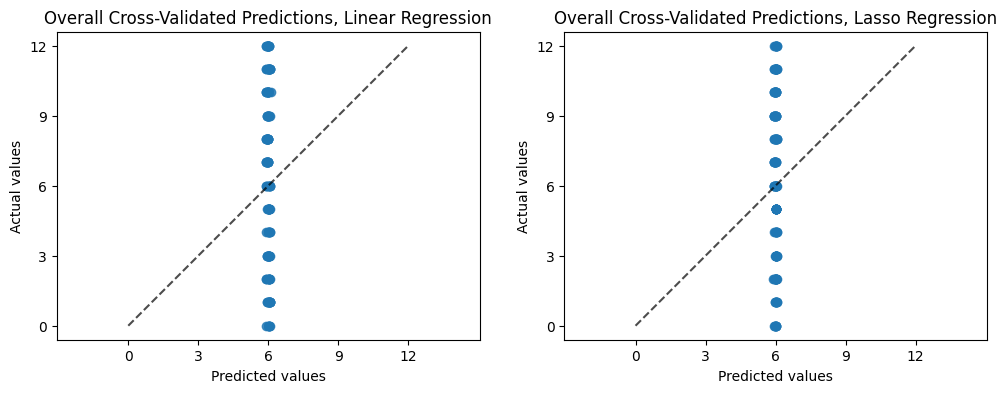

In [53]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, z, c, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, z, c, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(c, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(c, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

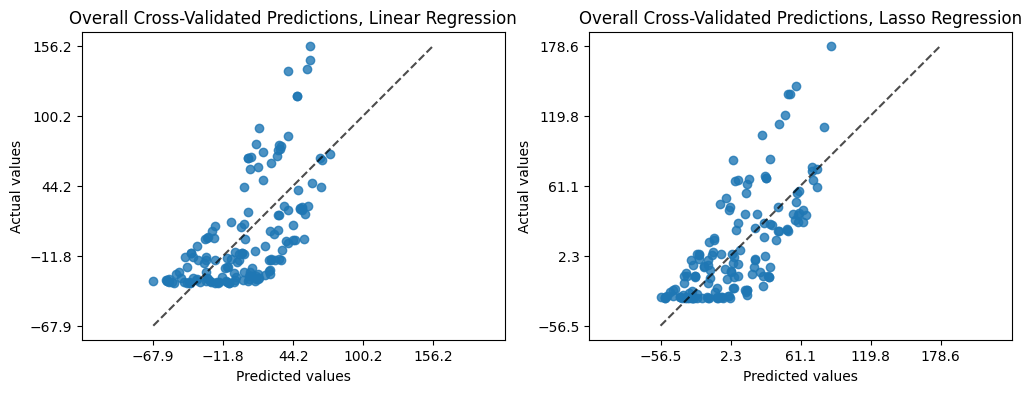

In [54]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, d1, d2, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, d1, d2, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(d2, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(d2, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

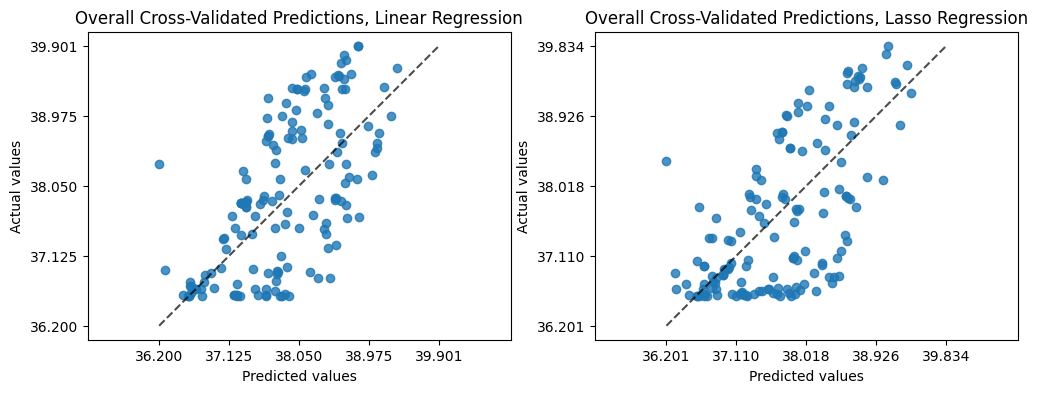

In [55]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, d1, d3, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, d1, d3, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(d3, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(d3, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()

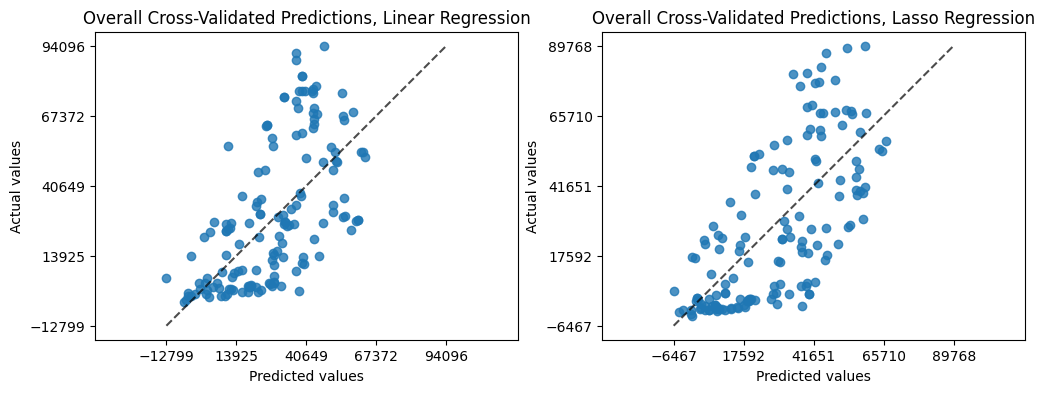

In [56]:
# Perform cross-validation prediction on the ENTIRE dataset
# The 'kf' object is used internally by cross_val_predict to define the splits
predicted_all = cross_val_predict(model, d1, d4, cv=kf)
predicted_all_lasso = cross_val_predict(lasso, d1, d4, cv=kf)

# Plot the overall results (Actual vs. Predicted)
fig, ax = plt.subplots(ncols =2, figsize=(12,4))
ax[0].set_title('Overall Cross-Validated Predictions, Linear Regression')
ax[1].set_title('Overall Cross-Validated Predictions, Lasso Regression')

PredictionErrorDisplay.from_predictions(d4, predicted_all, kind='actual_vs_predicted',
                                        ax=ax[0], subsample=150)
PredictionErrorDisplay.from_predictions(d4, predicted_all_lasso, kind='actual_vs_predicted',
                                        ax=ax[1], subsample=150)
plt.show()